In [1]:
#start port tunneling
#configure to use db_profile.json locally
import utils.retrieve_model_fits as rmf
from utils.run_models_funs import get_model_data
import json
import ast
from sklearn.grid_search import ParameterGrid
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import numpy as np
import pandas as pd

In [2]:
from sklearn.cross_validation import train_test_split  
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_curve,roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
sns.set_style('darkgrid')
import math

%matplotlib inline

In [45]:
#get_models(models_schema, models_table, ids=None)
#200 features ish includes time
#models = rmf.get_models("models", "underreporting_mult2",['126','127','128','129','130','131']) #, ['1', '2'])

#200 features ish no time
#models = rmf.get_models("models", "underreporting_mult3",['90','91','92','93']) # 10, 50, 10, 50

#200 features ish no time ( no estimated income )
models = rmf.get_models("models", "underreporting_mult4",['139','140','141','142']) # 10, 50, 10, 50


count     5110
unique       2
top          0
freq      4001
Name: has_underreporting, dtype: int64
Precision at 5:  0.341366757797
Recall at 5:  0.0785439703858
model_139_resp_has_underreporting_rf_cl064342049e010af0447a2a5acc2_rmse_0.1676_auc_0.60765.png
/Users/dolano/Desktop/figs_0919/precision_recall_udrpt_num_139_resp_has_underreporting.png


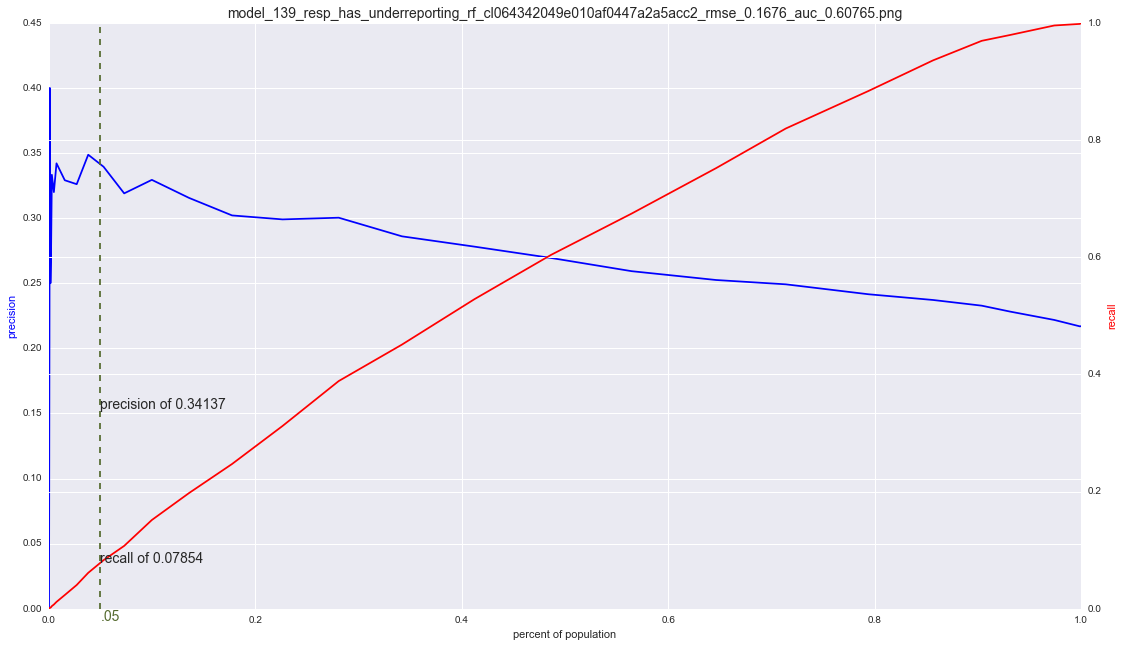

Feature ranking: (sorted by importance)
1. actual_age_as_of_16_dec_2015 [col: 112] (0.033176)
2. spending_food [col: 6] (0.032187)
3. n_rooms [col: 117] (0.018505)
4. n_bedrooms [col: 152] (0.013228)
5. spending_clothes [col: 148] (0.012068)
6. meals_per_day [col: 92] (0.009997)
7. own_stove_12 [col: 346] (0.009316)
8. educational_attainment_0 [col: 156] (0.008068)
9. food_frequency_sugars_1 [col: 297] (0.007779)
10. food_frequency_legumes_1 [col: 284] (0.007540)
11. indicator_food_deprivation [col: 86] (0.007402)
12. own_stove_11 [col: 345] (0.007337)
13. toilet_1 [col: 361] (0.007206)
14. food_frequency_fruit_5 [col: 183] (0.007076)
15. indicator_for_health_care_deprivation [col: 109] (0.007015)
16. water_source_1 [col: 309] (0.007002)
17. food_frequency_sugars_2 [col: 298] (0.006966)
18. food_frequency_meat_4 [col: 352] (0.006942)
19. gender_1 [col: 262] (0.006920)
20. under_minimum_poverty_line [col: 3] (0.006820)
21. food_frequency_vegetables_2 [col: 174] (0.006780)
22. food_frequ

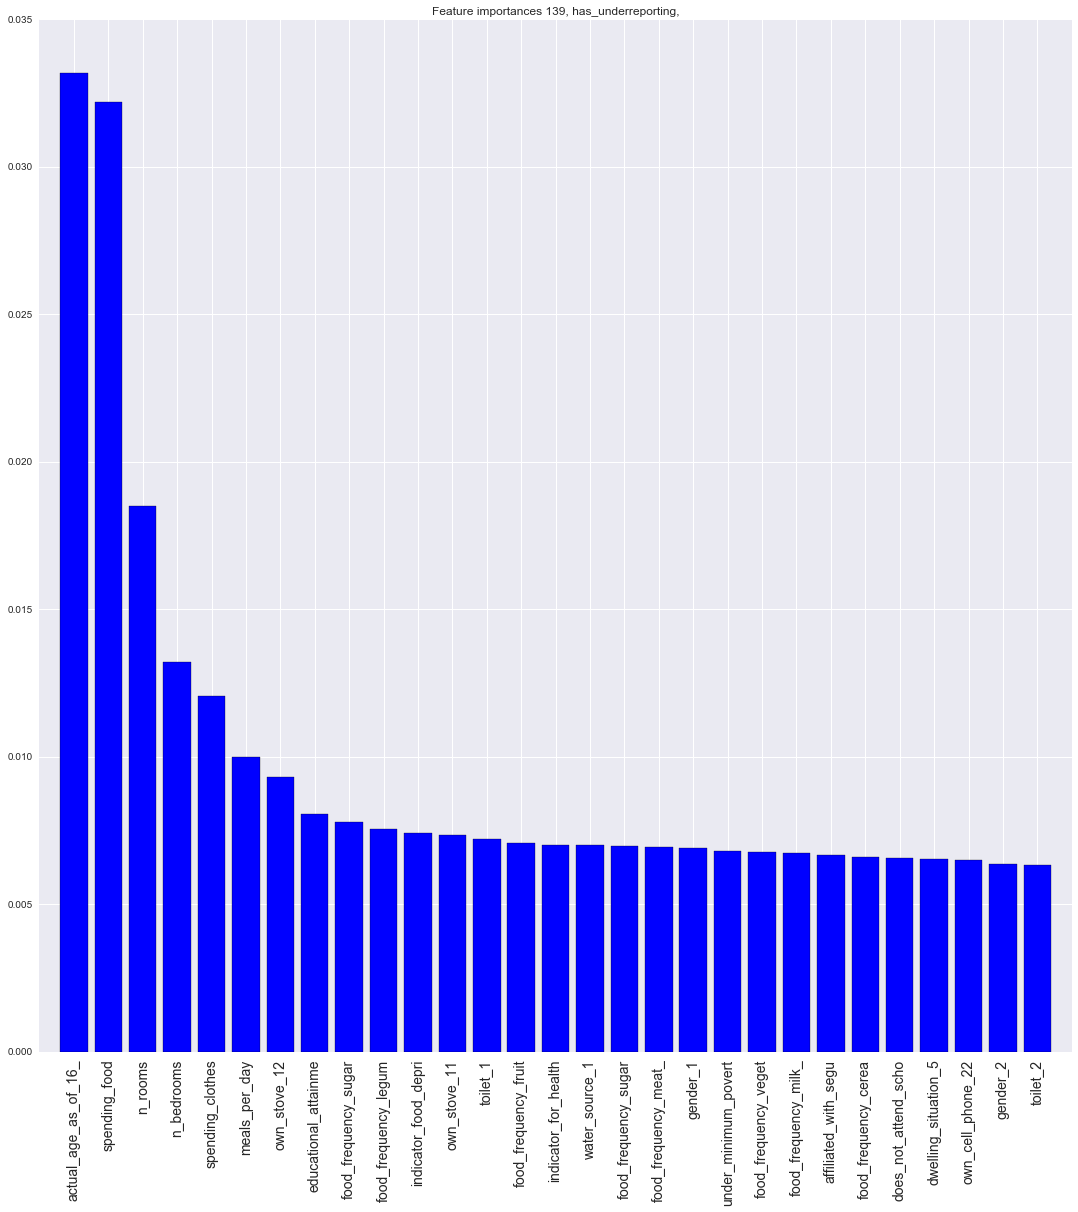

In [46]:
mnum = '139'
resp = 'has_underreporting'  #'has_discrepancy'  , 'has_underreporting'
models_out = {}

for curnum in [mnum]: #models.keys():
    modelnum = curnum
    model_data_schema = models[modelnum]["model_data_schema"]
    model_fits = models[modelnum]["fits"]

    # get predictions for model
    basenames = json.loads(models[modelnum]["model_data"])
    model_data = get_model_data(basenames, model_data_schema, "intersection")                          
    preds = rmf.get_model_preds(model_fits, model_data)   
    models_out[modelnum] = {'model_fits':model_fits,'model_data':model_data,'model_preds':preds}

modelnum = mnum
m33 = models_out[modelnum]
cl1 = m33['model_fits'][resp]

test_features = m33['model_data']['test_features']
test_responses = m33['model_data']['test_responses']

test_labels = test_responses[resp]
predictions = m33['model_preds']['test'][resp]

y_true = test_labels
y_score = predictions

print(test_labels.astype('category').describe())     #39469 out of 49848 are 0  ( so positive)

plot_precision_recall(y_true,y_score,models[modelnum]['string'],modelnum,resp)
plot_feature_importance(cl1,test_features,models[modelnum]['string'],modelnum,resp)

In [178]:
#print(test_labels.astype('category').describe())     #for has_underreporting ( test is 0:1778 and 1: 187)  9.5%
                                                     #for has_discrepancy    ( test is 0:1438 and 1: 517)  26%
#print(predictions.head())
#test_labels[test_labels == 1].size    #10379

10379

In [6]:
def plot_precision_recall(y_true,y_score,modelname,modelnum,resp):

    rmse = round(mean_squared_error(y_true, y_score),5)
    auc_score = round(roc_auc_score(y_true, y_score),5)

    #SET MODEL NAME AND FEATSET USED!!
    model_name = "model_%s_resp_%s_%s_rmse_%s_auc_%s.png" % (modelnum,resp,modelname,rmse,auc_score)

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    #pr_thresholds = np.append(pr_thresholds, 1)

    #print(precision_curve[0:10])
    #print(recall_curve[0:10])

    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)

    top5threshold_value = .05
    num_above_5thresh = len(y_score[y_score>=top5threshold_value])
    pct_above_5thresh = num_above_5thresh / float(number_scored)


    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')

    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')


    if .05 not in pct_above_per_thresh:
        below_ind = np.argmax(pct_above_per_thresh < .05)
        one_below = pct_above_per_thresh[below_ind]

        above_ind = np.where(pct_above_per_thresh > .05)[0][-1]
        one_above = pct_above_per_thresh[above_ind]

        rbelow = recall_curve[below_ind]    #x1: one_below  y1: rbelow
        rabove = recall_curve[above_ind]    #x2: one_above  y2: rabove
        rslope = (rabove - rbelow) / (one_above - one_below) 
        ryint = rbelow - (one_below * rslope) 
        rat5 = (rslope * .05) + ryint

        pbelow = precision_curve[below_ind]    
        pabove = precision_curve[above_ind]    
        pslope = (pabove - pbelow) / (one_above - one_below)
        pyint = pbelow - (one_below * pslope)
        pat5 = (pslope * .05) + pyint

    pr_at5 = pat5
    plt.text(.05, pr_at5 , 'precision of %s' % round(pr_at5,5) , fontsize=14)
    plt.plot((.05, .05), (0, 1), color='darkolivegreen', linestyle='dashed')
    plt.text(.05, -.02, '.05', color='darkolivegreen',fontsize=14)
    re_at5 = rat5
    plt.text(.05, re_at5 , 'recall of %s' % round(re_at5,5) , fontsize=14)


    print("Precision at 5: ",pat5)
    print("Recall at 5: ",rat5)


    name = model_name

    #saveto = "/Users/dolano/Desktop/precision_recall_%s" % (model_name)
    saveto = "/Users/dolano/Desktop/figs_0919/precision_recall_udrpt_num_%s_resp_%s.png" % (modelnum,resp)

    print(name)
    print(saveto)

    plt.title(name, fontsize=14)
    fig.set_size_inches(18.5, 10.5, forward=True)
    fig.savefig(saveto, dpi=100)
    plt.show()
    plt.close()

In [7]:
def plot_feature_importance(clf,signals,modelname,modelnum,resp):
    #GET FEATURE IMPORTANCE FOR RFs and ExtraTrees
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking: (sorted by importance)")

    i = 1
    for f in indices:
        print("%d. %s [col: %d] (%f)" % (i, signals.columns[f], f, importances[f]))
        i = i + 1

    signals_sorted = signals[indices]    
    signals_sorted_top30 = signals_sorted[signals_sorted.columns[1:30]]

    # Plot the feature importances of the forest
    plt.clf()
    fig, ax1 = plt.subplots()

    plt.title("Feature importances %s, %s," % (modelnum,resp))
    xnames = [a[0:20] for a in signals.columns[indices[0:31]] ]

    plt.bar(range(signals_sorted_top30.shape[1]), importances[indices][0:29], color="b", align="center")
    plt.xticks(range(signals_sorted_top30.shape[1]), xnames, rotation=90, fontsize=14)
    plt.xlim([-1, signals_sorted_top30.shape[1]])

    saveto = "/Users/dolano/Desktop/figs_0919/feature_importances_model_%s_resp_%s_%s" % (modelnum,resp,modelname)
    fig.set_size_inches(18.5, 18.5, forward=True)
    fig.savefig(saveto, dpi=100 )
    plt.show()
    plt.close()

In [27]:
import utils.pg_sedesol as pg_sed
colname = 'date_of_survey'
q = "SELECT  %s FROM semantic_underreport.pmhmll10k" % colname
conn = pg_sed.db_connection()
X = pd.io.sql.read_sql(q, conn)

date_start = pd.to_datetime(X[colname],infer_datetime_format=True)
feats = ["year","day","month","dayofweek","minute","hour","dayofyear","weekofyear","is_month_start","is_month_end","is_year_start","is_year_end"]
feats_d = date_start.apply(lambda x: [ getattr(x,f) if hasattr(x,f) else None for f in feats ])


In [32]:
feats_data = pd.DataFrame(list(feats_d),columns=[colname + "_" + c for c in feats])

#TODO: handle the 127 year old in data cleaning, but for now just give null value
start_seconds = date_start.apply(lambda x: x.timestamp() if hasattr(x,'timestamp') and str(type(x)) != "<class 'pandas.tslib.NaTType'>" and str(x) != '1888-07-08 18:00:00' else None)
epoch_time_start = pd.DataFrame( list(start_seconds),columns=[colname + '_start_timestamp'])

#current_age = date_start.apply( lambda x: math.floor((x.tz_convert(None).today() - x.tz_convert(None) ).days / 365) if hasattr(x,'today') and str(type(x)) != "<class 'pandas.tslib.NaTType'>" else None )
#print(date_start)

In [ ]:
'''
1. poverty distance, bandwidth ( estimated )
2. distance self reported
'''

In [28]:
#Poverty distance 
import utils.pg_sedesol as pg_sed

In [29]:
def get_distance_between_estimated_income_and_povertyline():
    query = "Select home_id, income_self_reported, estimated_income, type_of_locality, manzana_id, locality_id, municipality_id, state_id FROM semantic_underreport.prospera_houses_with_manzanas"
    conn = pg_sed.db_connection()
    X = pd.io.sql.read_sql(query, conn)
    return X

In [30]:
prospera_df = get_distance_between_estimated_income_and_povertyline()

In [31]:
pr_df_back = prospera_df

In [32]:
#prospera_df.shape   #(409211, 4)
#prospera_df[ prospera_df.type_of_locality == 'U'].shape           #(253379, 4)  urban
#prospera_df[ prospera_df.type_of_locality == 'R'].shape           #(125604, 4)  rural
#prospera_df[~prospera_df.type_of_locality.isin(['U','R'])].shape  #( 30228, 4)  none
prospera_df.loc[~prospera_df.type_of_locality.isin(['U','R']),'type_of_locality'] = 'NA'

In [33]:
prospera_df.type_of_locality.unique()

array(['NA', 'R', 'U'], dtype=object)

In [34]:
prospera_df[['estimated_income','income_self_reported','type_of_locality']].groupby(['type_of_locality']).agg(['mean','median', 'count'])

estimated_income                      income_self_reported  \
                             mean       median   count                 mean   
type_of_locality                                                              
NA                            NaN          NaN       0          1538.615181   
R                      787.806455   654.250426  125604          1070.528775   
U                     1140.410072  1036.491441  253379          1600.800164   

                                 
                  median  count  
type_of_locality                 
NA                1000.0   4150  
R                  700.0  33884  
U                 1200.0  63447

In [35]:
#VARIABLES FOR PARTNER TO SET
urban_poverty = 1500
rural_poverty = 1000
bandwidth = 200

In [36]:
urban_mask = prospera_df.type_of_locality == 'U'
prospera_df.loc[ urban_mask, 'diff_from_poverty_line' ] = prospera_df[urban_mask]['estimated_income'].apply(lambda x: urban_poverty - x )

rural_mask = prospera_df.type_of_locality == 'R'
prospera_df.loc[ rural_mask, 'diff_from_poverty_line' ] = prospera_df[rural_mask]['estimated_income'].apply(lambda x: rural_poverty - x )

#prospera_df[prospera_df.type_of_locality.isin(['U','R']) & ~prospera_df.estimated_income.isnull()].head()

In [37]:
valid_incomes_mask = ~prospera_df.estimated_income.isnull() & ~prospera_df.income_self_reported.isnull()
prospera_df.loc[valid_incomes_mask,'diff_self_and_estimated_income'] = prospera_df[valid_incomes_mask]['estimated_income'] - prospera_df[valid_incomes_mask]['income_self_reported']

#prospera_df[valid_incomes_mask].head()

In [38]:
#giving ranking based on incomes for people within bandwidth
people_around_poverty_line = abs(prospera_df.diff_from_poverty_line) < bandwidth
prospera_df.loc[people_around_poverty_line,'around_poverty_cutoff'] = True
prospera_df.loc[~people_around_poverty_line,'around_poverty_cutoff'] = False

#prospera_df[people_around_poverty_line].head()

In [40]:
from IPython.display import display, HTML
p_around_pov = prospera_df[ prospera_df['around_poverty_cutoff'] == True]

print("Total families around cutoff: ",p_around_pov.shape[0], " out of ", prospera_df.shape[0])    # out of 409,000 families there are 67,879  within 200 pesos of the cutoff


#1a. show counts of people around cutoff by state 
cols = ['state_id','home_id']
grouped = p_around_pov[cols].groupby(['state_id']).agg(['count']).reset_index()
print("show counts of people around cutoff by state")
display(grouped.sort_values([('home_id','count')],ascending=False))


#1b. show counts of people around cutoff by state and around_poverty_cutoff or not
bcols = ['state_id','around_poverty_cutoff','home_id']
groupedb = prospera_df[bcols].groupby(['state_id','around_poverty_cutoff']).agg(['count'])
print("\nshow counts of people around cutoff by state and around_poverty_cutoff or not: ")
display(groupedb)


#2. show counts of people around cutoff by state and type of locality
scols = ['state_id','type_of_locality','around_poverty_cutoff']
grouped2 = prospera_df[scols].groupby(['state_id','type_of_locality']).agg(['count'])
print("\nshow counts of people around cutoff by state and type of locality")
display(grouped2)

#3. show split by state and then rural/urban showing estimated_income
ecols = ['type_of_locality','state_id','estimated_income','income_self_reported','diff_from_poverty_line','diff_self_and_estimated_income']
grouped3 = p_around_pov[ecols].groupby(['state_id','type_of_locality']).agg(['mean','median', 'count'])
print("\nshow split by state and then rural/urban showing estimated_income")
display(grouped3)


Total families around cutoff:  67879  out of  409211
show counts of people around cutoff by state


,state_id,home_id
,,count
14,15,20725
10,11,6415
6,07,4607
11,12,4284
26,27,3902
15,16,3591
29,30,3057
13,14,3014
7,08,2200



show counts of people around cutoff by state and around_poverty_cutoff or not: 


home_id
                                 count
state_id around_poverty_cutoff        
01       False                     574
         True                      148
02       False                    7344
         True                     1750
03       False                    1157
         True                      165
04       False                    3501
         True                      869
05       False                    2396
         True                      687
06       False                    1197
         True                      202
07       False                   36036
         True                     4607
08       False                    9867
         True                     2200
09       False                    1774
         True                      381
10       False                    3322
         True                      841
11       False                   25155
         True                     6415
12       False                   28716
         True                     4284
13       False                    1469
         True                      382
14       False                   16190
         True                     3014
15       False                   84784
         True                    20725
...                                ...
18       False                    1303
         True                      134
19       False                    2038
         True                      339
20       False                   14425
         True                     1403
21       False                    7709
         True                     1193
22       False                    7727
         True                     1855
23       False                    3193
         True                      704
24       False                    5052
         True                     1104
25       False                    2989
         True                      753
26       False                    1046
         True                      255
27       False                   15961
         True                     3902
28       False                    2427
         True                      586
29       False                     514
         True                      154
30       False                   13769
         True                     3057
31       False                    3598
         True                     1147
32       False                    1766
         True                      404

[64 rows x 1 columns]


show counts of people around cutoff by state and type of locality


around_poverty_cutoff
                                          count
state_id type_of_locality                      
01       NA                                  30
         R                                  229
         U                                  463
02       NA                                 475
         R                                 1446
         U                                 7173
03       NA                                  50
         R                                  145
         U                                 1127
04       NA                                 180
         R                                  979
         U                                 3211
05       NA                                 134
         R                                  235
         U                                 2714
06       NA                                  61
         R                                  140
         U                                 1198
07       NA                                1195
         R                                23977
         U                                15471
08       NA                                 557
         R                                 1633
         U                                 9877
09       NA                                 102
         R                                   35
         U                                 2018
10       NA                                 170
         R                                  591
         U                                 3402
...                                         ...
23       NA                                 172
         R                                  457
         U                                 3268
24       NA                                 266
         R                                 3294
         U                                 2596
25       NA                                 161
         R                                 1108
         U                                 2473
26       NA                                  50
         R                                  349
         U                                  902
27       NA                                 757
         R                                11368
         U                                 7738
28       NA                                 154
         R                                  178
         U                                 2681
29       NA                                  27
         R                                  107
         U                                  534
30       NA                                 631
         R                                 7427
         U                                 8768
31       NA                                 210
         R                                  454
         U                                 4081
32       NA                                  74
         R                                 1220
         U                                  876

[96 rows x 1 columns]


show split by state and then rural/urban showing estimated_income


estimated_income                      \
                                      mean       median  count   
state_id type_of_locality                                        
01       R                     1025.030691  1020.160418     44   
         U                     1497.262936  1479.911286    104   
02       R                     1008.074035  1019.274174    445   
         U                     1476.203507  1459.413386   1305   
03       R                      976.025317   977.525184     39   
         U                     1459.621652  1440.965211    126   
04       R                      977.339215   970.914794    254   
         U                     1476.637648  1458.859766    615   
05       R                     1014.212601  1032.271311     50   
         U                     1480.195375  1466.799910    637   
06       R                      984.395625   958.356668     33   
         U                     1479.373451  1472.965999    169   
07       R                      952.142726   933.723656   3083   
         U                     1455.003046  1431.039369   1524   
08       R                      958.359021   939.082845    208   
         U                     1479.390559  1472.126364   1992   
09       R                      995.797918  1010.213692     15   
         U                     1480.336339  1470.941839    366   
10       R                     1014.511767  1022.066616    136   
         U                     1463.666391  1444.591509    705   
11       R                      992.402406   988.250131   2917   
         U                     1480.546204  1474.118782   3498   
12       R                      963.718645   950.439614   2531   
         U                     1454.900009  1439.025696   1753   
13       R                      981.141664   970.870914    227   
         U                     1457.933359  1445.057509    155   
14       R                      975.204994   966.034046    202   
         U                     1479.722380  1470.171974   2812   
15       R                      981.954663   971.783894   5673   
         U                     1474.653133  1462.332641  15052   
...                                    ...          ...    ...   
18       R                      929.230896   890.529150     99   
         U                     1461.270667  1443.050753     35   
19       R                      963.287130   957.470033     53   
         U                     1457.523230  1430.771928    286   
20       R                      953.999643   932.669925    865   
         U                     1457.538068  1436.434643    538   
21       R                      960.619766   952.887733    500   
         U                     1461.127603  1445.288321    693   
22       R                     1000.310467   993.123823    655   
         U                     1482.443859  1467.698828   1200   
23       R                      979.605808   967.268490    112   
         U                     1484.111346  1473.961459    592   
24       R                      962.391721   944.551311    563   
         U                     1486.484326  1477.713707    541   
25       R                      976.245430   965.520857    319   
         U                     1456.664392  1444.195727    434   
26       R                      989.456033   977.509511     88   
         U                     1490.361397  1485.708607    167   
27       R                      977.698103   970.174099   2870   
         U                     1470.667065  1454.119266   1032   
28       R                      984.811380   990.581472     47   
         U                     1471.043804  1450.755990    539   
29       R                      983.646644   983.623302     31   
         U                     1491.474671  1485.890959    123   
30       R                      969.700107   960.774339   1461   
         U                     1463.755867  1447.176196   1596   
31       R                      975.803885   955.469063    104   


In [44]:
#these are the families around the poverty line order by the bandwidth 200 ( we'll need to change this to a weight distribution)
p_around_pov.sort_values(['diff_from_poverty_line'],ascending=True).head()

,home_id,income_self_reported,estimated_income,type_of_locality,manzana_id,locality_id,municipality_id,state_id,diff_from_poverty_line,diff_self_and_estimated_income,around_poverty_cutoff
140813,000151302703584-0020130714610022153232-0000000...,2000.0,1699.975665,U,None,220160001,22016,22,-199.975665,-300.024335,True
128267,000151301765641-0020130629654222150943-0000000...,NaN,1699.951576,U,None,150810019,15081,15,-199.951576,NaN,True
139558,000151302625513-0020130618639252151011-0000000...,NaN,1699.938798,U,None,151210001,15121,15,-199.938798,NaN,True
28158,000051000025242-0020130802604203113204-0045001...,NaN,1699.926895,U,None,050170001,05017,05,-199.926895,NaN,True
72471,000111300996497-0020130525605241125034-0000000...,700.0,1699.914923,U,None,110370001,11037,11,-199.914923,999.914923,True
